In [1]:
!pip install -q tensorflow==2.7.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.2.0.dev0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,<2.6,>=1.15.2, but you have tensorflow 2.7.0 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

In [6]:
test = pd.read_csv('/Users/yuzhang/Downloads/data/test.csv')
train = pd.read_csv('/Users/yuzhang/Downloads/data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train.shape

(7613, 5)

In [8]:
test.shape

(3263, 4)

In [9]:
train.location.value_counts()

USA                       104
New York                   71
United States              50
London                     45
Canada                     29
                         ... 
Land of Lincoln             1
Tafekop Ga-Matsepe          1
hey Georgia                 1
Sacramento, California      1
SaudI arabia - riyadh       1
Name: location, Length: 3341, dtype: int64

#### Data Wrangling

In [10]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [12]:
train['keyword'].replace(np.NAN,"", inplace=True)
train['location'].replace(np.NAN,"", inplace=True)
test['keyword'].replace(np.NAN,"", inplace=True)
test['location'].replace(np.NAN,"", inplace=True)

In [13]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [14]:
test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [15]:
len(test['keyword'])

3263

#### Exploratory Data Analysis & Data Processing
#### Tokenize Texts
#### Show Statistics info of texts

In [16]:
contents = []
for data in [train, test]:
    for i in range(data.shape[0]):
        item=data.iloc[i]
        sentence=item["keyword"]+" "+item["text"]+" "+item["location"]
        contents.append(sentence.lower())

In [17]:
train_contents=contents[:len(train)]
test_contents=contents[:len(test)]

In [19]:
train["X"]=train_contents
test["X"]=test_contents

#### TF-IDF Vectorization

In [21]:
vocab_size=10000
text_vectorizer=layers.TextVectorization(max_tokens=vocab_size, output_mode="tf-idf", ngrams=2)

with tf.device("CPU"):
    text_vectorizer.adapt(contents)

#### Model Development 
#### Binary Cross Entropy with Weights

In [22]:
class BinaryCrossEntropy(tf.keras.losses.Loss):
    
    def __init__(self, positive_rate=0.5):
        super().__init__()
        self.negative_weights = positive_rate
        self.positive_weights = 1 - positive_rate
        
    def call(self, y_true, y_pred):
        print(y_true, y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        pos = self.positive_weights*y_true*tf.math.log(y_pred+tf.keras.backend.epsilon())
        neg = self.negative_weights*(1.0-y_true)*tf.math.log(1.0-y_pred+tf.keras.backend.epsilon())
        return-(pos+neg)

#### Text Classification Model

In [26]:
def get_model():
    inputs = layers.Input(shape=(None,), dtype="string")
    x = text_vectorizer(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model=get_model()
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Fold 1
Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model/dense_1/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model/dense_1/Sigmoid:0", shape=(None, 1), dtype=float32)
191/191 [==============================] - 2s 4ms/step - loss: 0.3689 - accuracy: 0.6123 - val_loss: 0.2519 - val_accuracy: 0.7728
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.2282 - accuracy: 0.7885 - val_loss: 0.2298 - val_accuracy: 0.7919
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 0.1854 - accuracy: 0.8443 - val_loss: 0.2235 - val_accuracy: 0.8076
Epoch 4/100
191/191 [==============================] - 1s 3ms/step - loss: 0.1550 - accuracy: 0.8796 - val_loss: 0.2278 - val_accuracy: 0.7892
Epoch 5/100
191/191 [==============================] - 1s 4ms/step - loss: 0.1353 - accuracy: 0.8984 - val_loss: 0.2310 - val_accuracy: 0.8089
Epoch 6/100
191/191 [=========

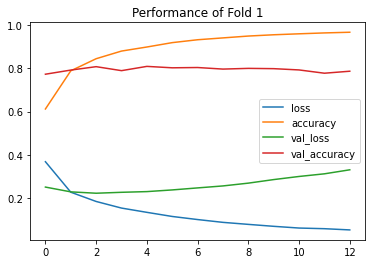

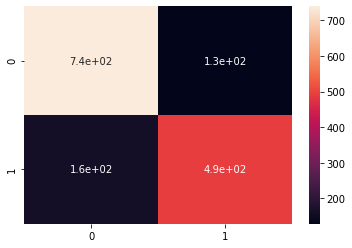

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       868
           1       0.79      0.75      0.77       655

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Accuracy Score: 0.81
Fold 2
Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_1/dense_3/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_1/dense_3/Sigmoid:0", shape=(None, 1), dtype=float32)
191/191 [==============================] - 2s 5ms/step - loss: 0.3437 - accuracy: 0.6209 - val_loss: 0.2590 - val_accuracy: 0.7656
Epoch 2/100
191/191 [==============================] - 1s 4ms/step - loss: 0.2243 - accuracy: 0.7992 - val_loss: 0.2396 - val_accuracy: 0.7761
Epoch 3/100
191/191 [==============================] - 1s 4ms/step - loss: 0.1835 

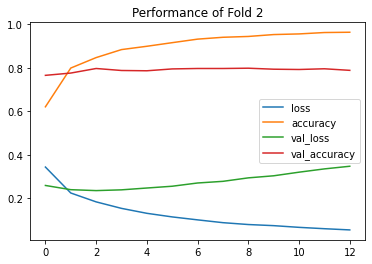

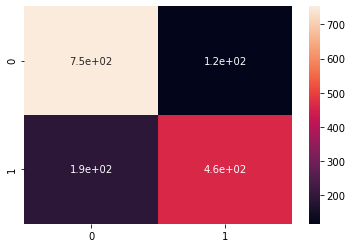

Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.80      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy Score: 0.80
Fold 3
Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_2/dense_5/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_2/dense_5/Sigmoid:0", shape=(None, 1), dtype=float32)
191/191 [==============================] - 1s 5ms/step - loss: 0.3253 - accuracy: 0.6238 - val_loss: 0.2754 - val_accuracy: 0.7531
Epoch 2/100
191/191 [==============================] - 1s 5ms/step - loss: 0.2392 - accuracy: 0.7842 - val_loss: 0.2416 - val_accuracy: 0.7787
Epoch 3/100
191/191 [==============================] - 1s 4ms/step - loss: 0.1938 

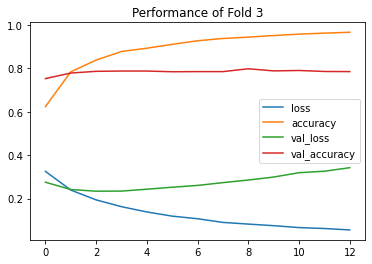

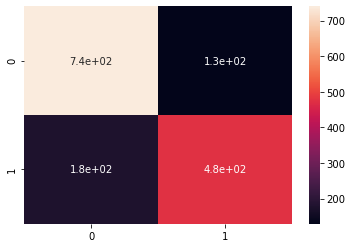

Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       869
           1       0.79      0.73      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy Score: 0.80
Fold 4
Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_3/dense_7/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_3/dense_7/Sigmoid:0", shape=(None, 1), dtype=float32)
191/191 [==============================] - 1s 4ms/step - loss: 0.3375 - accuracy: 0.6239 - val_loss: 0.2648 - val_accuracy: 0.7628
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.2361 - accuracy: 0.7859 - val_loss: 0.2350 - val_accuracy: 0.7898
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 0.1887 

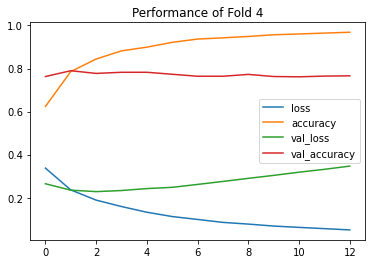

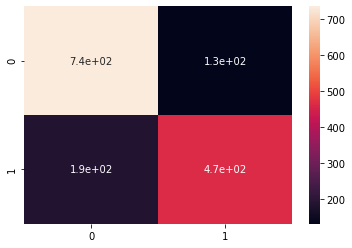

Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       868
           1       0.78      0.71      0.74       654

    accuracy                           0.79      1522
   macro avg       0.79      0.78      0.78      1522
weighted avg       0.79      0.79      0.79      1522

Accuracy Score: 0.79
Fold 5
Epoch 1/100
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_4/dense_9/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 1), dtype=int64) Tensor("model_4/dense_9/Sigmoid:0", shape=(None, 1), dtype=float32)
191/191 [==============================] - 1s 4ms/step - loss: 0.3374 - accuracy: 0.6114 - val_loss: 0.2673 - val_accuracy: 0.7635
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.2406 - accuracy: 0.7710 - val_loss: 0.2388 - val_accuracy: 0.7917
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 0.1970 

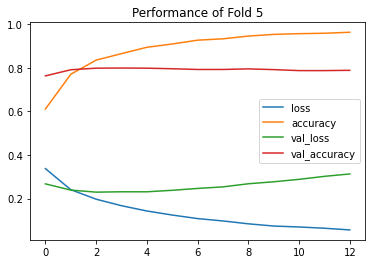

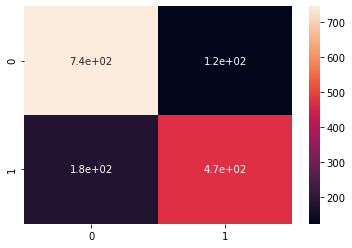

Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       868
           1       0.79      0.72      0.76       654

    accuracy                           0.80      1522
   macro avg       0.80      0.79      0.79      1522
weighted avg       0.80      0.80      0.80      1522

Accuracy Score: 0.80


In [37]:
index = 1
models = []
tf.keras.backend.clear_session()
for train_indices, val_indices in StratifiedKFold(5, shuffle=True, random_state=42).split(train, train["target"]):
    print("Fold %d" %(index))
    train_features, train_targets = train.iloc[train_indices]["X"], train.iloc[train_indices]["target"]
    validation_features, validation_targets = train.iloc[val_indices]["X"], train.iloc[val_indices]["target"]
    model_checkpoint_path = "model%d.tf"%(index)
    model = get_model()
    loss = BinaryCrossEntropy(train_targets.mean())
    adam = tf.keras.optimizers.Adam(3e-4)
    model.compile(loss=loss, optimizer=adam, metrics=["accuracy"])
    early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
    recuce_Lf=tf.keras.callbacks.ReduceLROnPlateau(patience=2)
    model_checkpoint=tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor="val_accuracy", save_best_only=True,
                                                       save_weights_only=True)
    history=model.fit(train_features, train_targets, validation_data=(validation_features, validation_targets), epochs=100, 
                     callbacks=[early_stop, model_checkpoint])
    pd.DataFrame(history.history).plot(kind="line")
    plt.title("Performance of Fold %d"%(index))
    plt.show()
    model.load_weights(model_checkpoint_path)
    y_val_pred=np.array(model.predict(validation_features)>0.5, dtype="int").reshape(-1)
    cm=confusion_matrix(validation_targets, y_val_pred)
    sns.heatmap(cm, annot=True)
    plt.show()
    print("Classification Report: \n")
    print(classification_report(validation_targets, y_val_pred))
    acc_score=accuracy_score(validation_targets, y_val_pred)
    print("Accuracy Score: %.2f"%(acc_score))
    models.append(model)
    index += 1

#### Submission

In [ ]:
y_test = np.mean([model.predict(test["X"]).reshape(-1) for model in models], axis=0)
y_test = np.array(y_test > 0.5, dtype = int)
submissoin = pd.DataFrame({"id":test["id"], "target": y_test})
submission.to_csv("submission.csv", index=False)